In [101]:
import pandas as pd
import numpy as np

import source.utility as ut
import source.transf_univ as df_p
import source.report as rp

from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, log_loss

from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_columns', 300)

In [2]:
df = pd.read_csv('data/processed_men/training_data.csv')

df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T1_FGM2,T1_FGA2,T1_Tot_Reb,T1_FGM_no_ast,T1_possessions,T1_off_rating,T1_scoring_opp,T1_TO_perposs,T1_def_rating,T1_impact,T1_Def_effort,T1_Reb_opp,T1_Score_diff,T1_FGM_diff,T1_FGA_diff,T1_FGM3_diff,T1_FGA3_diff,T1_FTM_diff,T1_FTA_diff,T1_OR_diff,T1_DR_diff,T1_Ast_diff,T1_TO_diff,T1_Stl_diff,T1_Blk_diff,T1_PF_diff,T1_FGM2_diff,T1_FGA2_diff,T1_Tot_Reb_diff,T1_FGM_no_ast_diff,T1_Def_effort_diff,T1_Reb_opp_diff,T1_possessions_diff,T1_off_rating_diff,T1_def_rating_diff,T1_scoring_opp_diff,T1_TO_perposs_diff,T1_impact_diff,T1_N_wins,T1_FGM_perc,T1_FGM2_perc,T1_FGM3_perc,T1_FT_perc,T1_FGM_no_ast_perc,T1_L2W_Score,T1_L2W_FGM,T1_L2W_FGA,T1_L2W_FGM3,T1_L2W_FGA3,T1_L2W_FTM,T1_L2W_FTA,T1_L2W_OR,T1_L2W_DR,T1_L2W_Ast,T1_L2W_TO,T1_L2W_Stl,T1_L2W_Blk,T1_L2W_PF,T1_L2W_FGM2,T1_L2W_FGA2,T1_L2W_Tot_Reb,T1_L2W_FGM_no_ast,T1_L2W_possessions,T1_L2W_off_rating,T1_L2W_scoring_opp,T1_L2W_TO_perposs,T1_L2W_def_rating,T1_L2W_impact,T1_L2W_Def_effort,T1_L2W_Reb_opp,T1_L2W_Score_diff,T1_L2W_FGM_diff,T1_L2W_FGA_diff,T1_L2W_FGM3_diff,T1_L2W_FGA3_diff,T1_L2W_FTM_diff,T1_L2W_FTA_diff,T1_L2W_OR_diff,T1_L2W_DR_diff,T1_L2W_Ast_diff,T1_L2W_TO_diff,T1_L2W_Stl_diff,T1_L2W_Blk_diff,T1_L2W_PF_diff,T1_L2W_FGM2_diff,T1_L2W_FGA2_diff,T1_L2W_Tot_Reb_diff,T1_L2W_FGM_no_ast_diff,T1_L2W_Def_effort_diff,T1_L2W_Reb_opp_diff,T1_L2W_possessions_diff,T1_L2W_off_rating_diff,T1_L2W_def_rating_diff,T1_L2W_scoring_opp_diff,T1_L2W_TO_perposs_diff,T1_L2W_impact_diff,T1_L2W_N_wins,T1_L2W_FGM_perc,T1_L2W_FGM2_perc,T1_L2W_FGM3_perc,T1_L2W_FT_perc,T1_L2W_FGM_no_ast_perc,T1_Seed,T2_Score,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T2_FGM2,T2_FGA2,T2_Tot_Reb,T2_FGM_no_ast,T2_possessions,T2_off_rating,T2_scoring_opp,T2_TO_perposs,T2_def_rating,T2_impact,...,T2_L2W_FGM_diff,T2_L2W_FGA_diff,T2_L2W_FGM3_diff,T2_L2W_FGA3_diff,T2_L2W_FTM_diff,T2_L2W_FTA_diff,T2_L2W_OR_diff,T2_L2W_DR_diff,T2_L2W_Ast_diff,T2_L2W_TO_diff,T2_L2W_Stl_diff,T2_L2W_Blk_diff,T2_L2W_PF_diff,T2_L2W_FGM2_diff,T2_L2W_FGA2_diff,T2_L2W_Tot_Reb_diff,T2_L2W_FGM_no_ast_diff,T2_L2W_Def_effort_diff,T2_L2W_Reb_opp_diff,T2_L2W_possessions_diff,T2_L2W_off_rating_diff,T2_L2W_def_rating_diff,T2_L2W_scoring_opp_diff,T2_L2W_TO_perposs_diff,T2_L2W_impact_diff,T2_L2W_N_wins,T2_L2W_FGM_perc,T2_L2W_FGM2_perc,T2_L2W_FGM3_perc,T2_L2W_FT_perc,T2_L2W_FGM_no_ast_perc,T2_Seed,delta_Loc,delta_Score,delta_FGM,delta_FGA,delta_FGM3,delta_FGA3,delta_FTM,delta_FTA,delta_OR,delta_DR,delta_Ast,delta_TO,delta_Stl,delta_Blk,delta_PF,delta_FGM2,delta_FGA2,delta_Tot_Reb,delta_FGM_no_ast,delta_possessions,delta_off_rating,delta_scoring_opp,delta_TO_perposs,delta_def_rating,delta_impact,delta_Def_effort,delta_Reb_opp,delta_Score_diff,delta_FGM_diff,delta_FGA_diff,delta_FGM3_diff,delta_FGA3_diff,delta_FTM_diff,delta_FTA_diff,delta_OR_diff,delta_DR_diff,delta_Ast_diff,delta_TO_diff,delta_Stl_diff,delta_Blk_diff,delta_PF_diff,delta_FGM2_diff,delta_FGA2_diff,delta_Tot_Reb_diff,delta_FGM_no_ast_diff,delta_Def_effort_diff,delta_Reb_opp_diff,delta_possessions_diff,delta_off_rating_diff,delta_def_rating_diff,delta_scoring_opp_diff,delta_TO_perposs_diff,delta_impact_diff,delta_N_wins,delta_FGM_perc,delta_FGM2_perc,delta_FGM3_perc,delta_FT_perc,delta_FGM_no_ast_perc,delta_L2W_Score,delta_L2W_FGM,delta_L2W_FGA,delta_L2W_FGM3,delta_L2W_FGA3,delta_L2W_FTM,delta_L2W_FTA,delta_L2W_OR,delta_L2W_DR,delta_L2W_Ast,delta_L2W_TO,delta_L2W_Stl,delta_L2W_Blk,delta_L2W_PF,delta_L2W_FGM2,delta_L2W_FGA2,delta_L2W_Tot_Reb,delta_L2W_FGM_no_ast,delta_L2W_possessions,delta_L2W_off_rating,delta_L2W_scoring_opp,delta_L2W_TO_perposs,delta_L2W_def_rating,delta_L2W_impact,delta_L2W_Def_effort,delta_L2W_Reb_opp,delta_L2W_Score_diff,delta_L2W_FGM_diff,delta_L2W_FGA_diff,delta_L2W_FGM3_diff,delta_L2W_FGA3_diff,delta_L2W_FTM_diff,delta_L2W_FTA_diff,delta_L2W_OR_diff,delta_L2W_DR_diff,delta_L2W_Ast

* Both on target and target_points
* General 80/20 split, Kfold and test results
* kfold on n-1 season and test on the remaining one

In [25]:
def _clean_columns(train, test):
    for col in ['target', 'target_points', 'ID', 'DayNum', 'Team1', 'Team2', 'Season']:
        try:
            del train[col]
            del test[col]
        except KeyError:
            pass
    return train, test


def _make_preds(train, y_train, test, model, kfolds, predict_proba):
    oof, imp_coef = ut.cv_score(train, y_train, kfolds, model, imp_coef=True, predict_proba=predict_proba)
    
    fit_model = model.fit(train, y_train)
    if predict_proba:
        predictions = fit_model.predict_proba(test)[:,1]
    else:
        predictions = fit_model.predict(test)
    
    return fit_model, oof, imp_coef, predictions


def random_split(data, model, kfolds, target, test_size=0.2, predict_proba=False):
    
    train, test = ut.make_test(data, test_size=test_size, random_state=324)
    
    y_train = train[target]
    y_test = test[target]
    
    train, test = _clean_columns(train, test)
    
    fit_model, oof, imp_coef, predictions = _make_preds(train, y_train, test, model, kfolds, predict_proba)
    
    return fit_model, oof, predictions, imp_coef, train, y_train, test, y_test

In [58]:
df_train = df[['Season', 'target', 'target_points', 'ID', 'delta_Seed', 'delta_Score']]

df_train.head()

,Season,target,target_points,ID,delta_Seed,delta_Score
0,2003,0,-8,2003_1411_1421,0.0,1.593103
1,2003,1,29,2003_1112_1436,-15.0,17.421182
2,2003,1,13,2003_1113_1272,3.0,1.448276
3,2003,1,6,2003_1141_1166,5.0,0.102403
4,2003,1,2,2003_1143_1301,-1.0,2.082759


In [78]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('ridge', Ridge())])

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')

In [28]:
imp_coef

,mean,std
feat,,
delta_Seed,-8.194218,0.129185
delta_Score,0.738528,0.118569


In [113]:
def _point_to_proba(oof, y_train, preds):
    dat = list(zip(np.clip(oof, -30, 30), np.where(y_train > 0, 1, 0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {dat[k][0]: dat[k][1] for k in range(len(dat))}

    spline_model = UnivariateSpline(list(datdict.keys()), list(datdict.values()))  
    spline_oof = spline_model(oof)
    spline_test = spline_model(preds)
    
    return spline_oof, spline_test


def _plot_proba(score, label, spline, ax):
    plot_df = pd.DataFrame({"pred": score, 
                            "label": np.where(label > 0, 1, 0), 
                            "spline": spline})
    plot_df["pred_int"] = (plot_df["pred"]).astype(int)
    plot_df = plot_df.groupby('pred_int', as_index=False)['spline','label'].mean()
    
    ax.plot(plot_df.pred_int,plot_df.spline, label='Spline')
    ax.plot(plot_df.pred_int,plot_df.label, label='Score')
    ax.legend()
    ax.set_xlabel('Predicted score')
    ax.set_ylabel('Predicted probability')
    
    return ax


def report_points(train, test, y_train, y_test, oof, preds, plot=True):
    mae_oof = round(mean_absolute_error(y_true=y_train, y_pred=oof), 4)
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=preds), 4)
    mse_oof = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=oof)), 4)
    mse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=preds)), 4)
    acc_oof = round(accuracy_score(y_true=(y_train>0).astype(int), y_pred=(oof>0).astype(int)),4)
    acc_test = round(accuracy_score(y_true=(y_test>0).astype(int), y_pred=(preds>0).astype(int)),4)
    n_unsure_oof = round((abs(oof) < 1).mean() * 100, 2)
    n_unsure_test = round((abs(preds) < 1).mean() * 100, 2)
    
    # transform into probabilities
    spline_oof, spline_test = _point_to_proba(oof, y_train, preds)
    
    logloss_oof = round(log_loss(y_true=np.where(y_train > 0, 1, 0), y_pred=spline_oof), 4)
    logloss_test = round(log_loss(y_true=np.where(y_test > 0, 1, 0), y_pred=spline_test), 4)
    
    if plot:
        # plot_proba
        fig, ax = plt.subplots(1,2, figsize=(15, 6))

        ax[0] = _plot_proba(oof, y_train, spline_oof, ax[0])
        ax[0].set_title('Training data')

        ax[1] = _plot_proba(preds, y_test, spline_test, ax[1])
        ax[1].set_title('Test data')

        fig.suptitle('Probabilities of victory via splines', fontsize=15)

        # plot predictions
        rp.plot_predictions(train, y_train, oof, savename=False)
        rp.plot_predictions(test, y_test, preds, savename=False)
    
    print(f'MAE train: \t\t\t {mae_oof}')
    print(f'MAE test: \t\t\t {mae_test}')
    print(f'RMSE train: \t\t\t {mse_oof}')
    print(f'RMSE test: \t\t\t {mse_test}')
    print(f'Accuracy train: \t\t {acc_oof}')
    print(f'Accuracy test: \t\t\t {acc_test}')
    print(f'Logloss train: \t\t\t {logloss_oof}')
    print(f'Logloss test: \t\t\t {logloss_test}')
    print(f'Unsure train: \t\t\t {n_unsure_oof}%')
    print(f'Unsure test: \t\t\t {n_unsure_test}%')

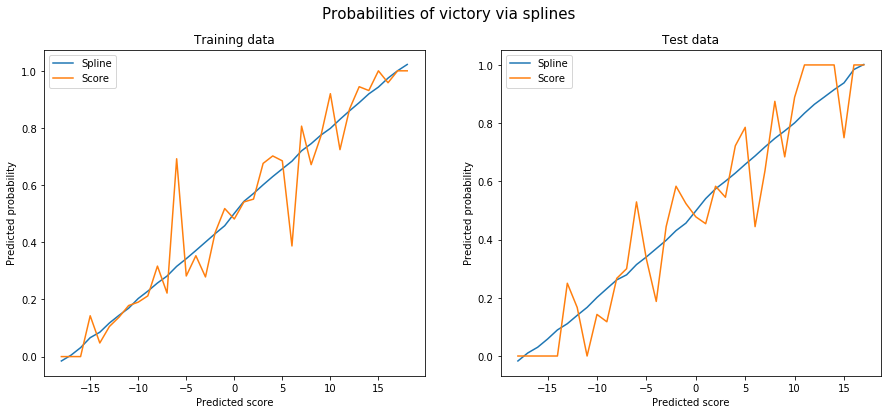

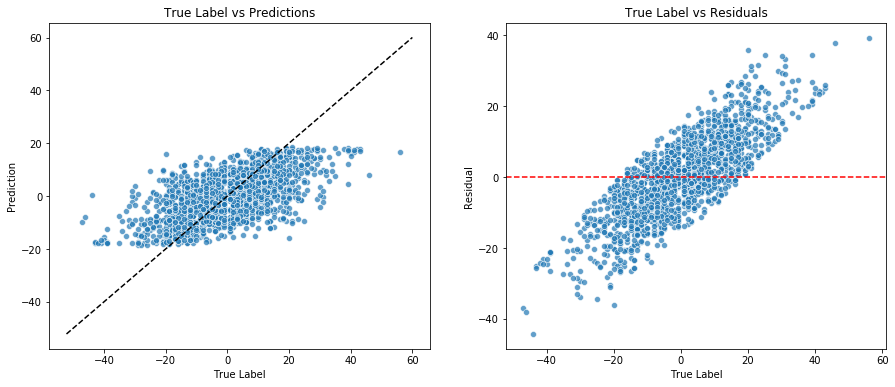

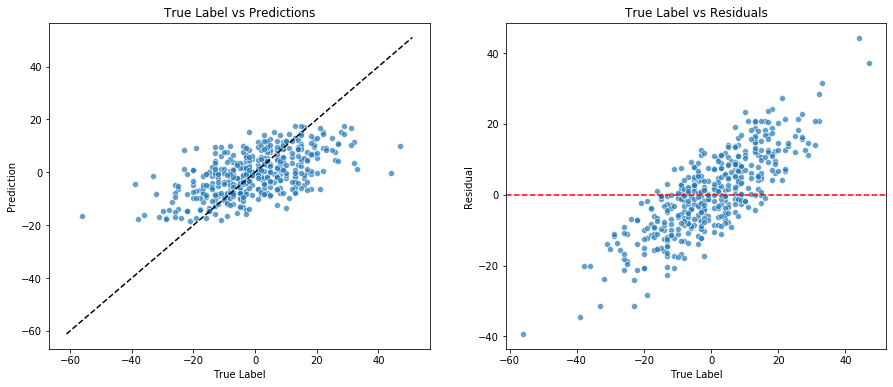

MAE train: 			 8.9889
MAE test: 			 8.9094
RMSE train: 			 11.5134
RMSE test: 			 11.4124
Accuracy train: 		 0.6999
Accuracy test: 			 0.6952
Logloss train: 			 0.5551
Logloss test: 			 0.5482
Unsure train: 			 9.6659%
Unsure test: 			 10.9524%


In [108]:
report_points(train, test, y_train, y_test, oof_pred, test_pred)

In [110]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('logit', LogisticRegression(solver='lbfgs', multi_class='auto'))])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target', predict_proba=True)

In [111]:
imp_coef

,mean,std
feat,,
delta_Seed,-1.161836,0.044797
delta_Score,0.128212,0.034697


In [55]:
def report_victory(y_train, y_test, oof, preds, probs=True):
    
    if probs:
        acc_oof = round(accuracy_score(y_true=y_train, y_pred=(oof>0.5).astype(int)),4)
        acc_test = round(accuracy_score(y_true=y_test, y_pred=(preds>0.5).astype(int)),4)
        n_unsure_oof = round((abs(oof - 0.5) < 0.05).mean() * 100, 4)
        n_unsure_test = round((abs(preds - 0.5) < 0.05).mean() * 100, 4)
        logloss_oof = round(log_loss(y_true=y_train, y_pred=oof), 4)
        logloss_test = round(log_loss(y_true=y_test, y_pred=preds), 4)
    
    print(acc_oof, acc_test, n_unsure_oof, n_unsure_test, logloss_oof, logloss_test)

In [56]:
report_victory(y_train, y_test, oof_pred, test_pred)

0.6999 0.6952 13.4845 15.7143 0.562 0.5545


In [112]:
def yearly_split(data, model, kfolds, target, predict_proba=False):
    
    fit_model = {}
    oof = {}
    imp_coef = {}
    train = {}
    test = {}
    y_train = {}
    y_test = {}
    predictions = {}
    
    for year in data.Season.unique():
        yr = str(year)
        train[yr] = data[data.Season != year].copy()
        test[yr] = data[data.Season == year].copy()
    
        y_train[yr] = train[yr][target]
        y_test[yr] = test[yr][target]

        train[yr], test[yr] = _clean_columns(train[yr], test[yr])
        
        fit_model[yr], oof[yr], imp_coef[yr], predictions[yr] = _make_preds(train[yr], 
                                                                            y_train[yr], 
                                                                            test[yr], 
                                                                            model, 
                                                                            kfolds, 
                                                                            predict_proba)
    
    return fit_model, oof, predictions, imp_coef, train, y_train, test, y_test

In [114]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('ridge', Ridge())])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target_points')

In [115]:
fitted.keys()

dict_keys(['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [143]:
def yearly_wrapper(train, test, y_train, y_test, oof, preds):
    y_train_total = []
    y_test_total = []
    oof_total = []
    preds_total = []
    for yr in train.keys():
        print(yr)
        print('\n')
        report_points(train[yr], test[yr], y_train[yr], y_test[yr], oof[yr], preds[yr], plot=False)
        print('\n')
        print('_'*40)
        print('\n')
        y_train_total.append(y_train[yr])
        y_test_total.append(y_test[yr])
        oof_total += list(oof[yr])
        preds_total += list(preds[yr])
        
    print('Total predictions')
    print('\n')
    y_train_total = pd.concat(y_train_total, ignore_index=True)
    y_test_total = pd.concat(y_test_total, ignore_index=True)
    oof_total = pd.Series(oof_total)
    preds_total = pd.Series(preds_total)
    report_points(train[yr], test[yr], y_train_total, y_test_total, oof_total, preds_total, plot=False)

In [144]:
yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred)

2003


MAE train: 			 8.9643
MAE test: 			 9.049
RMSE train: 			 11.486
RMSE test: 			 11.5769
Accuracy train: 		 0.7017
Accuracy test: 			 0.6562
Logloss train: 			 0.5559
Logloss test: 			 0.5158
Unsure train: 			 10.06%
Unsure test: 			 7.81%


________________________________________


2004


MAE train: 			 9.0112
MAE test: 			 8.2983
RMSE train: 			 11.5465
RMSE test: 			 10.5782
Accuracy train: 		 0.6977
Accuracy test: 			 0.7344
Logloss train: 			 0.556
Logloss test: 			 0.5108
Unsure train: 			 10.37%
Unsure test: 			 4.69%


________________________________________


2005


MAE train: 			 9.0585
MAE test: 			 7.5976
RMSE train: 			 11.6033
RMSE test: 			 9.5796
Accuracy train: 		 0.6992
Accuracy test: 			 0.7031
Logloss train: 			 0.5539
Logloss test: 			 0.54
Unsure train: 			 10.16%
Unsure test: 			 6.25%


________________________________________


2006


MAE train: 			 8.986
MAE test: 			 8.8093
RMSE train: 			 11.5526
RMSE test: 			 10.5603
Accuracy train: 		 0.7017
Accur

In [38]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('logit', LogisticRegression(solver='lbfgs', multi_class='auto'))])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target', predict_proba=True)